# Mask inspection project

We will use deep learning to classify images taken from quality inspection machine during production of breathing masks.  The masks are checked for one of 13 different defects, with images taken one at a time.

In [1]:
import os
from matplotlib import pyplot as plt

%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

## Initial data review

In [2]:
PATH = 'data/缺陷原图/'
sz = 224

In [3]:
os.listdir(f'{PATH}/train')

['耳带打结',
 '.DS_Store',
 '反面毛发',
 '鼻梁条歪斜',
 '反正污渍图',
 '好品原图',
 '耳带短',
 '主体穿孔有破洞',
 '鼻梁条短',
 '上部没包好边',
 '叠片',
 '正面污渍图',
 '耳带断裂',
 '焊点处有露头',
 '焊点位置不对',
 '正面毛发图']

In [4]:
files = os.listdir(f'{PATH}/train/耳带打结/')
files

['1.tiff', '.DS_Store']

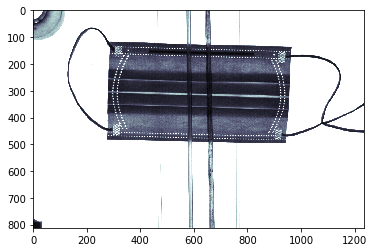

In [5]:
img = plt.imread(f'{PATH}/train/耳带打结/{files[0]}')
plt.imshow(img,cmap='bone');

In [6]:
img.shape

(812, 1236)

## Using scripts from fast.ai course (new 2018 version, lesson1)

In [7]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [8]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

For now using same dataset for training and validation.

**NOTE:** this is very wrong, but don't seem to have enough data to make a good split for now

In [12]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz),trn_name='train', val_name='valid',num_workers=2)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.02, 100)

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   accuracy   
    0      3.07175    3.887254   0.060606  
    1      2.974364   3.770281   0.060606  
    2      2.810272   3.722461   0.060606  
    3      2.574889   3.631681   0.060606  
    4      2.365879   3.517686   0.060606  
    5      2.166051   3.353826   0.060606  
    6      1.974774   3.171291   0.090909  
    7      1.822398   2.947862   0.121212  
    8      1.683236   2.711499   0.151515  
    9      1.540908   2.484922   0.30303   
    10     1.40591    2.269479   0.363636  
    11     1.290738   2.073982   0.454545  
    12     1.195353   1.894693   0.484848  
    13     1.110842   1.73608    0.545455  
    14     1.033591   1.622058   0.545455  
    15     0.96626    1.550614   0.545455  
    16     0.903624   1.509697   0.545455  
    17     0.848555   1.486248   0.545455  
    18     0.798407   1.479905   0.575758  
    19     0.751985   1.48209    0.575758  
    20     0.71153    1.485373   0.575758  
    21     0.673825   1.491464 

[1.7959613, 0.5757575757575758]

## Now to review the train dataset and the results

First looking at the labels for the data, we started with 14 folders, and each image is assigned a label based on the folder.

In [13]:
data.val_y

array([ 0,  1,  2,  3,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,
        7,  8,  9, 10, 11, 12, 13, 14])

We can see the names of the classes

In [14]:
data.classes

['上部没包好边',
 '主体穿孔有破洞',
 '反正污渍图',
 '反面毛发',
 '叠片',
 '好品原图',
 '正面毛发图',
 '正面污渍图',
 '焊点位置不对',
 '焊点处有露头',
 '耳带打结',
 '耳带断裂',
 '耳带短',
 '鼻梁条歪斜',
 '鼻梁条短']

In [15]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(33, 15)

In [16]:
# this shows log probability for the first image
log_preds[:1]

array([[-3.69075, -5.31619, -4.91372, -5.51396, -3.43528, -0.51098, -5.87188, -6.07133, -2.7464 , -3.0431 ,
        -3.78329, -3.16256, -2.63754, -2.79874, -4.40844]], dtype=float32)

In [17]:
# predicted label for each image
preds = np.argmax(log_preds, axis=1)  
preds

array([ 5,  5,  3,  2,  6,  5,  5,  5,  5,  5, 13,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  7,
        7,  5,  5,  1, 13, 14,  5,  1])

In [18]:
# probability for chosen category
probs = np.exp(np.max(log_preds,axis=1))
np.round(probs,decimals=2)

array([0.6 , 1.  , 0.58, 0.99, 0.22, 0.99, 1.  , 0.79, 1.  , 1.  , 0.4 , 0.96, 1.  , 0.97, 1.  , 1.  , 1.  ,
       0.99, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.46, 0.91, 0.42, 0.37, 0.22, 0.42, 0.24],
      dtype=float32)

In [19]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [20]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [u'p={0:1.2}, label={1}'.format(probs[x],preds[x]) for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [21]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i],cmap='bone')

In [22]:
def load_img_id(ds, idx): return np.array(PIL.Image.open('data/'+ds.fnames[idx]))

In [23]:
data.val_ds.fnames

['valid/上部没包好边/2.tiff',
 'valid/主体穿孔有破洞/2.tiff',
 'valid/反正污渍图/原图1.bmp',
 'valid/反面毛发/原图1.bmp',
 'valid/叠片/焊接时三片有交叠.tiff',
 'valid/好品原图/正面检测18.tiff',
 'valid/好品原图/反面检测10.tiff',
 'valid/好品原图/外形检测11.tiff',
 'valid/好品原图/正面检测7.tiff',
 'valid/好品原图/正面检测12.tiff',
 'valid/好品原图/外形检测9.tiff',
 'valid/好品原图/外形检测8.tiff',
 'valid/好品原图/正面检测13.tiff',
 'valid/好品原图/外形检测10.tiff',
 'valid/好品原图/反面检测11.tiff',
 'valid/好品原图/反面检测7.tiff',
 'valid/好品原图/反面检测12.tiff',
 'valid/好品原图/外形检测7.tiff',
 'valid/好品原图/正面检测9.tiff',
 'valid/好品原图/反面检测8.tiff',
 'valid/好品原图/正面检测10.tiff',
 'valid/好品原图/外形检测12.tiff',
 'valid/好品原图/正面检测11.tiff',
 'valid/好品原图/反面检测9.tiff',
 'valid/正面毛发图/原图.bmp',
 'valid/正面污渍图/原图3.bmp',
 'valid/焊点位置不对/焊点位置不合格.tiff',
 'valid/焊点处有露头/2.tiff',
 'valid/耳带打结/2.tiff',
 'valid/耳带断裂/2.tiff',
 'valid/耳带短/左耳带短1.tiff',
 'valid/鼻梁条歪斜/鼻梁条歪斜2.tiff',
 'valid/鼻梁条短/2.tiff']

Correctly classified


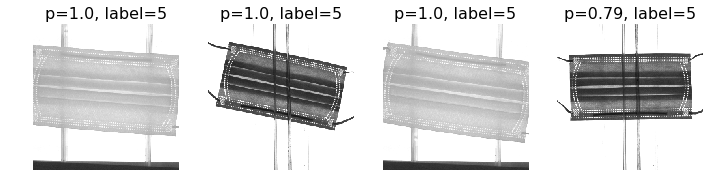

In [24]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


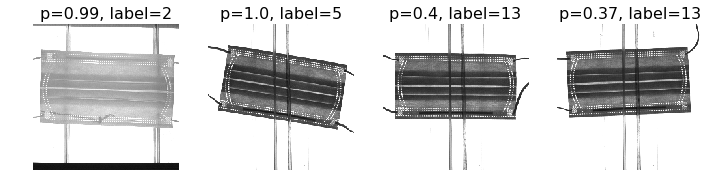

In [25]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")